In [1]:
!pip install pandas scikit-learn matplotlib seaborn geopandas xgboost

In [2]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import zipfile
import os

# Model dan Metrik dari Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Model XGBoost
from xgboost import XGBClassifier

# Untuk upload file di Colab
from google.colab import files

# Untuk legenda peta
import matplotlib.patches as mpatches

In [3]:
file_paths = [
    '/content/DKI_prediksi_banjir.csv',
    '/content/DKI_penggunaan_lahan.csv',
    '/content/DKI_riwayat_banjir.csv',
    '/content/DKI_non_spasial.csv',
    '/content/DKI_curah_hujan.csv'
]

# Membaca data dari file CSV
df_prediksi_banjir = pd.read_csv(file_paths[0])
df_penggunaan_lahan = pd.read_csv(file_paths[1])
df_riwayat_banjir = pd.read_csv(file_paths[2])
df_non_spasial = pd.read_csv(file_paths[3])
df_curah_hujan = pd.read_csv(file_paths[4])

# Menampilkan 5 baris pertama untuk memeriksa data
print("\nData Prediksi Banjir:")
print(df_prediksi_banjir.head())

print("\nData Penggunaan Lahan:")
print(df_penggunaan_lahan.head())

print("\nData Riwayat Banjir:")
print(df_riwayat_banjir.head())

print("\nData Non-Spasial:")
print(df_non_spasial.head())

print("\nData Curah Hujan:")
print(df_curah_hujan.head())



Data Prediksi Banjir:
    Kabupaten/Kota  Prediksi Banjir
0    Jakarta Timur                0
1  Jakarta Selatan                1
2    Jakarta Barat                0
3  Jakarta Selatan                0
4  Jakarta Selatan                0

Data Penggunaan Lahan:
    Kabupaten/Kota  Lahan Sawah (ha)  Lahan Permukiman (ha)  \
0  Jakarta Selatan                79                   7041   
1  Jakarta Selatan                62                   4105   
2  Jakarta Selatan                62                   4886   
3    Jakarta Barat                67                   4427   
4    Jakarta Barat                81                   9424   

   Lahan Perkebunan (ha)  Lahan Hutan (ha)  Lahan Terbuka (ha)  \
0                    136               109                1627   
1                    167               137                1603   
2                    149               195                1781   
3                    123               191                2946   
4                    118    

In [4]:
# Menggabungkan data berdasarkan kolom 'Kabupaten/Kota' dan 'Lokasi'
df_combined = pd.merge(df_penggunaan_lahan, df_riwayat_banjir, left_on="Kabupaten/Kota", right_on="Lokasi", how="left")

# Menambahkan data curah hujan berdasarkan kolom 'ID'
df_combined = pd.merge(df_combined, df_curah_hujan, on="ID", how="left")

# Menambahkan data non spasial berdasarkan kolom 'Lokasi' di df_non_spasial dan 'Kabupaten/Kota' di df_combined
df_combined = pd.merge(df_combined, df_non_spasial, left_on="Kabupaten/Kota", right_on="Lokasi", how="left")

# Menampilkan hasil gabungan
print("\nData Gabungan setelah Penggabungan Non-Spasial:")
print(df_combined.head())




Data Gabungan setelah Penggabungan Non-Spasial:
    Kabupaten/Kota  Lahan Sawah (ha)  Lahan Permukiman (ha)  \
0  Jakarta Selatan                79                   7041   
1  Jakarta Selatan                79                   7041   
2  Jakarta Selatan                79                   7041   
3  Jakarta Selatan                79                   7041   
4  Jakarta Selatan                79                   7041   

   Lahan Perkebunan (ha)  Lahan Hutan (ha)  Lahan Terbuka (ha)  \
0                    136               109                1627   
1                    136               109                1627   
2                    136               109                1627   
3                    136               109                1627   
4                    136               109                1627   

   Total Luas Penggunaan Lahan (ha)  ID_x         Lokasi_x  Tahun_x  ...  \
0                              8992     4  Jakarta Selatan     2019  ...   
1                      

In [5]:
# Membuat salinan dataframe untuk fitur baru
df_engineered = df_combined.copy()

# Menghitung persentase untuk setiap jenis lahan
df_engineered['%_Sawah'] = (df_engineered['Lahan Sawah (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Permukiman'] = (df_engineered['Lahan Permukiman (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Perkebunan'] = (df_engineered['Lahan Perkebunan (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Hutan'] = (df_engineered['Lahan Hutan (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100
df_engineered['%_Terbuka'] = (df_engineered['Lahan Terbuka (ha)'] / df_engineered['Total Luas Penggunaan Lahan (ha)']) * 100

# Menampilkan fitur yang baru dibuat
print("\nData dengan Fitur Persentase Penggunaan Lahan:")
print(df_engineered[['Kabupaten/Kota', '%_Hutan', '%_Permukiman', 'Pernah Banjir']].head())



Data dengan Fitur Persentase Penggunaan Lahan:
    Kabupaten/Kota   %_Hutan  %_Permukiman  Pernah Banjir
0  Jakarta Selatan  1.212189     78.302936              1
1  Jakarta Selatan  1.212189     78.302936              1
2  Jakarta Selatan  1.212189     78.302936              0
3  Jakarta Selatan  1.212189     78.302936              1
4  Jakarta Selatan  1.212189     78.302936              0


In [6]:
# Memilih fitur yang akan digunakan untuk prediksi
features = ['%_Sawah', '%_Permukiman', '%_Perkebunan', '%_Hutan', '%_Terbuka', 'Curah Hujan (mm)_y']
X = df_engineered[features].values
y = df_engineered['Pernah Banjir'].values

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, target, timestep=1):
    X, y = [], []
    for i in range(len(data) - timestep):
        X.append(data[i:(i + timestep), :])  # Mengambil data dari timestep sebelumnya
        y.append(target[i + timestep])  # Mengambil target pada timestep berikutnya
    return np.array(X), np.array(y)

# Menggunakan timestep=1 agar bisa bekerja dengan data yang lebih sedikit
timestep = 1  # Menggunakan 1 hari terakhir untuk prediksi
X_lstm, y_lstm = create_dataset(X_scaled, y, timestep)

# Memeriksa ukuran X_lstm dan y_lstm setelah perubahan timestep
print(f"Shape X_lstm: {X_lstm.shape}, Shape y_lstm: {y_lstm.shape}")

# Membagi data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)

# Menampilkan shape data latih dan uji
print(f"Shape X_train: {X_train.shape}, Shape X_test: {X_test.shape}")

Shape X_lstm: (2595017, 1, 6), Shape y_lstm: (2595017,)
Shape X_train: (1816511, 1, 6), Shape X_test: (778506, 1, 6)


Akurasi Model Random Forest: 0.9999

Laporan Klasifikasi Model Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242450
           1       1.00      1.00      1.00    536056

    accuracy                           1.00    778506
   macro avg       1.00      1.00      1.00    778506
weighted avg       1.00      1.00      1.00    778506



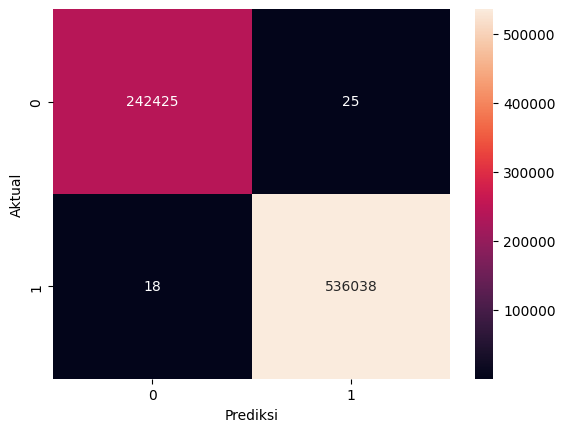

In [7]:
# Memilih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Prediksi dan evaluasi
y_pred = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model Random Forest: {accuracy:.4f}")

# Laporan Klasifikasi
print("\nLaporan Klasifikasi Model Random Forest:")
print(classification_report(y_test, y_pred))

# Matriks Confusion
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [8]:
# Melakukan cross-validation dengan 2-fold untuk mengatasi masalah kecilnya dataset
cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_scaled, y, cv=5)

# Menampilkan rata-rata akurasi dan deviasi standar dari cross-validation
print(f"Akurasi Cross-Validation: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Akurasi Cross-Validation: 0.7759 ± 0.0078



Classification Report untuk Model Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242450
           1       1.00      1.00      1.00    536056

    accuracy                           1.00    778506
   macro avg       1.00      1.00      1.00    778506
weighted avg       1.00      1.00      1.00    778506



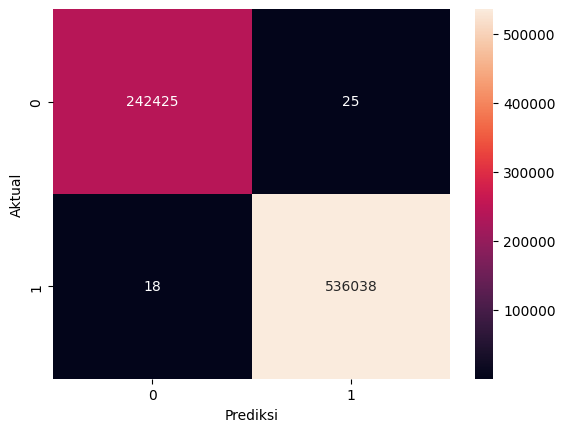

In [9]:
# Mengubah X_train dan X_test dari format 3D menjadi 2D untuk Random Forest
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Re-fit the model in case the previous cell was not run
# or if you want to ensure it's fitted before prediction in this block
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_2d, y_train) # Fit the model before predicting

# Melakukan prediksi pada data uji
y_pred = rf_model.predict(X_test_2d)

# Evaluasi model dengan classification report
print("\nClassification Report untuk Model Random Forest:")
print(classification_report(y_test, y_pred))

# Matriks konfusi
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()



Classification Report untuk Model Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242450
           1       1.00      1.00      1.00    536056

    accuracy                           1.00    778506
   macro avg       1.00      1.00      1.00    778506
weighted avg       1.00      1.00      1.00    778506



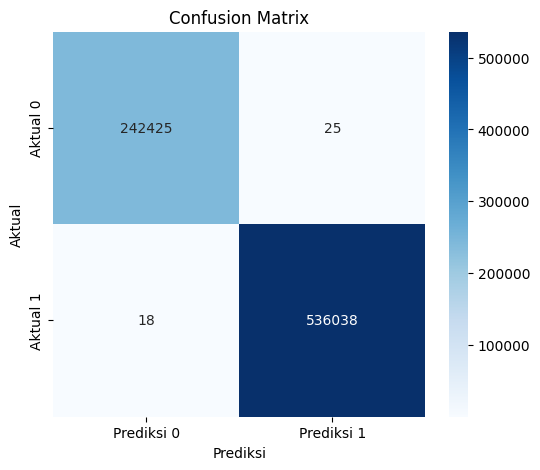

In [10]:
# Melakukan prediksi pada data uji dengan model yang sudah terlatih
y_pred = rf_model.predict(X_test_2d)  # Pastikan menggunakan model yang sudah terlatih sebelumnya

# Menampilkan classification report
print("\nClassification Report untuk Model Random Forest:")
print(classification_report(y_test, y_pred))

# Matriks Confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi Matriks Confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Prediksi 0', 'Prediksi 1'], yticklabels=['Aktual 0', 'Aktual 1'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

Saving Shapefile.zip to Shapefile.zip


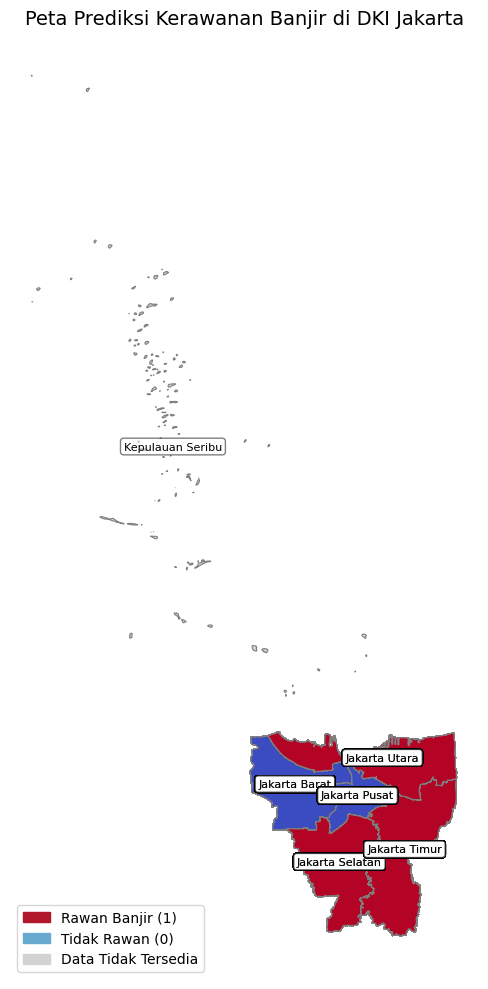

In [2]:
from google.colab import files
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import zipfile, os, pandas as pd

# --- 1. Upload Shapefile dan Dataset
uploaded = files.upload()  # Upload ZIP Shapefile dan CSV Prediksi
zip_file = "Shapefile.zip"
csv_file = "DKI_prediksi_banjir.csv"

# --- 2. Ekstrak shapefile
extract_dir = "shapefile_dki"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# --- 3. Cari file .shp
def find_shp(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.shp') and "2" in file.lower():
                return os.path.join(root, file)
shp_path = find_shp(extract_dir)

# --- 4. Load GeoDataFrame
gdf = gpd.read_file(shp_path)
gdf = gdf[gdf['NAME_1'].str.contains("Jakarta", case=False)].copy()
gdf['Kabupaten_Clean'] = gdf['NAME_2'].str.lower().str.replace("kota ", "").str.replace("kabupaten ", "").str.strip()

# --- 5. Load Data Prediksi
df_prediksi = pd.read_csv(csv_file)
df_prediksi['Kabupaten_Clean'] = df_prediksi['Kabupaten/Kota'].str.lower().str.replace("kota ", "").str.replace("kabupaten ", "").str.strip()

# --- 6. Merge Data
gdf_merged = gdf.merge(df_prediksi[['Kabupaten_Clean', 'Prediksi Banjir']], on='Kabupaten_Clean', how='left')

# --- 7. Plot Choropleth
fig, ax = plt.subplots(figsize=(10, 10))
gdf_merged.plot(
    column='Prediksi Banjir',
    cmap='coolwarm_r',
    linewidth=0.8,
    edgecolor='0.5',
    ax=ax,
    legend=False,
    missing_kwds={"color": "lightgrey", "label": "Data Tidak Tersedia"}
)

# --- 8. Tambahkan Label Wilayah
gdf_merged.apply(lambda x: ax.annotate(
    text=x['NAME_2'],
    xy=x.geometry.centroid.coords[0],
    ha='center',
    fontsize=8,
    bbox={"boxstyle": "round,pad=0.3", "fc": "white", "alpha": 0.5}
), axis=1)

# --- 9. Tambahkan Legenda
legend_patches = [
    mpatches.Patch(color='#b2182b', label='Rawan Banjir (1)'),
    mpatches.Patch(color='#67a9cf', label='Tidak Rawan (0)'),
    mpatches.Patch(color='lightgrey', label='Data Tidak Tersedia')
]
ax.legend(handles=legend_patches, loc='lower left')
ax.set_title("Peta Prediksi Kerawanan Banjir di DKI Jakarta", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()
